# CSC_52081_EP - Lab 03

### Main Objectives 

Today we will study bandits in the context of sequential decision making, and the exploration-exploitation tradeoff. You may find the required background in the lecture slides, lecture notes, and the references provided within. 
 
### Instructions

Work your way through the notebook, and provide code where indicated by `# TODO` to complete the tasks. Check Moodle for details on how to submit your work.

### Imports

First, we're going to import `numpy` and some utility functions/classes that we will use. Make sure the `bandit_machines.py` is in your working directory. 

In [25]:
import numpy as np
import scipy

In [26]:
import matplotlib.pyplot as plt

In [27]:
from bandit_machines import BernoulliMAB, GaussianMAB

In [28]:
def randmax(a):
    """ return a random maximum """
    a = np.array(a)  
    max_indices = np.flatnonzero(a == a.max())
    return np.random.choice(max_indices)

### Creating a bandit environment. 

What do we mean by a bandit environment or bandit machine? It's a kind of state-less enviornment. When generates from a particular generation, depending on which arm (or, action) is pulled (or, taken). 

In [29]:
n_arms = 2
env_B = BernoulliMAB(n_arms=2,labels=["Arm 1","Arm 2"],means=[0.5,0.7])
# 

### Evaluating a bandit learner

The function given below executes one bandit algorithm on one multi-armed-bandit (MAB) instance. We will use this to compare bandit algorithms. Note that we compare them on a basis of **cumulative regret**. In this lab we are mainly interested in an empirical analysis of bandits. 

In [30]:
def evaluate_run(env, pi, T=1000):
    '''
    Run a bandit agent on a bandit instance (environment) for T steps.
    '''
    r_log = []
    a_log = []
    pi.clear()
    for _ in range(T):
        a = pi.act()
        r = env.rwd(a)
        pi.update(a,r)
        r_log.append(r)
        a_log.append(a)
    return a_log, r_log

In [31]:
def cumulative_regret(env, selections):
    """Compute the pseudo-regret associated with a sequence of arm selections"""
    best = np.max(env.means)*np.ones(len(selections))
    real = np.array(env.means)[selections]
    return np.cumsum(best - real)

### Baselines

In the following, we implemented two naive bandit strategies: the greedy strategy (or Follow-the-Leader, `FTL`) and a strategy that explores arms uniformly at random (`UniformExploration`). 

Take note of the `class` structure (methods implemented), you will need to use the same structure in your implementations shortly. 

In [32]:
class FTL:

    """Follow the Leader (a.k.a. greedy strategy)"""

    def __init__(self,n_arms):
        self.n_arms = n_arms
        self.clear()

    def clear(self) -> None:
        self.nbDraws = np.zeros(self.n_arms)
        self.cumRewards = np.zeros(self.n_arms)
    
    def act(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            return randmax(self.cumRewards/self.nbDraws)

    def update(self,a,r):
        self.cumRewards[a] = self.cumRewards[a] + r
        self.nbDraws[a] = self.nbDraws[a] + 1

    def name(self):
        return "FTL"

In [33]:
class UniformExploration:

    """a strategy that uniformly explores arms"""

    def __init__(self,n_arms):
        self.n_arms = n_arms
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.n_arms)
        self.cumRewards = np.zeros(self.n_arms)
    
    def act(self):
        return np.random.randint(0,self.n_arms)

    def update(self, arm, reward) -> None:
        self.cumRewards[arm] = self.cumRewards[arm] + reward
        self.nbDraws[arm] = self.nbDraws[arm] + 1

    def name(self):
        return "Uniform"

Below we run `FTL` on the simple Bernoulli bandit instance defined above, and we visualize its behavior.

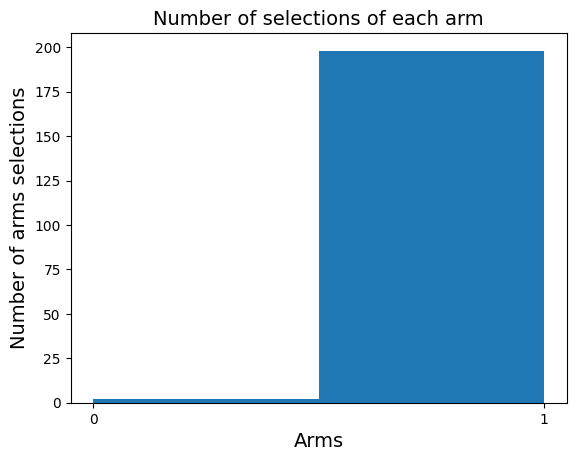

In [34]:
ftl = FTL(n_arms)
T = 200
actions, rewards = evaluate_run(env_B, ftl, T)
regret1 = cumulative_regret(env_B, actions)
# Histogram of the number of arms selections
plt.clf()
plt.xlabel("Arms", fontsize=14)
plt.xticks(range(ftl.n_arms))
plt.ylabel("Number of arms selections", fontsize=14)
plt.hist(actions, np.max(actions) + 1)
plt.title("Number of selections of each arm", fontsize=14)
plt.show()

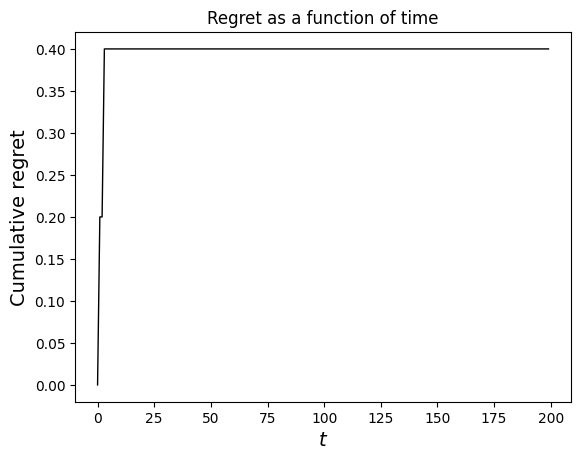

In [35]:
# Cumulative regret as a function of time
plt.figure(2)
plt.clf()
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(T), regret1, 'black', linewidth=1)
plt.show()

Let's compare regret between FTL and the Uniform algorithm.

You can run the code more than once, and you should get a different result each time.

In [36]:
# Compare their regret
ufm = UniformExploration(n_arms)
T = 200
actions, rewards = evaluate_run(env_B, ufm, T)
regret2 = cumulative_regret(env_B, actions)

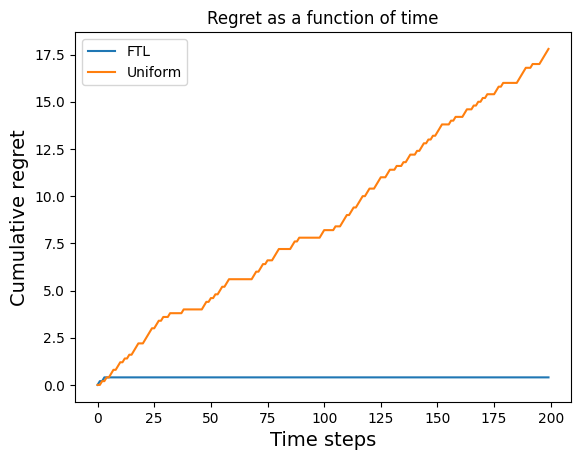

In [37]:
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(0, T), regret1,label=ftl.name())
plt.plot(range(0, T), regret2,label=ufm.name())
plt.legend()
plt.show()

### Comparison averaged over multiple runs

Since the regret is defined as an **expectation**, we need several runs to estimate its value. We can also take a look at the distribution of the pseudo-regret. The function below gathers results accross multiple runs.

In [38]:
def evaluate_runs(env, pi, T=1000, N=10):
    '''
        Parameters
        ----------

        env : 
            bandit machine
        pi : 
            bandit algorithm
        N : int
            number of experiments
        T : int
            number of trails per experiment
    '''
    R_log = np.zeros((N,T))
    A_log = np.zeros((N,T),dtype=int)
    for n in range(N):
        np.random.seed()
        A_log[n], R_log[n] = evaluate_run(env, pi, T)

    return A_log, R_log

The following function will be useful for comparing arbitrary combinations of bandit algorithms empirically under a number (`N`) of runs. 

In [39]:
def plot_results(env, algorithms, T=1000, N=10, fname=None): 

    plt.clf()
    plt.title("Cumulative Regret over %d Runs" % N)

    colours = ['b', 'r', 'g', 'm']

    for j, pi in enumerate(algorithms):

        A_log, R_log = evaluate_runs(env, pi, T, N)
        Regret = np.array([cumulative_regret(env,A_log[n,:]) for n in range(N)])
        meanRegret = np.mean(Regret, 0)
        upperQuantile = np.quantile(Regret, 0.95, 0) 
        lowerQuantile = np.quantile(Regret, 0.05, 0)

        plt.plot(range(T), meanRegret, linewidth=3.0, color=colours[j], label=""+pi.name())
        plt.plot(range(T), upperQuantile, linestyle="dashed", color=colours[j])
        plt.plot(range(T), lowerQuantile, linestyle="dashed", color=colours[j])

    plt.xlabel("$t$", fontsize=10)
    plt.ylabel("Cumulative regret", fontsize=10)
    plt.legend()
    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname,bbox_inches='tight')
    plt.show()

So now let's compare FTL and Uniform in terms of expectation. What do you observe? 

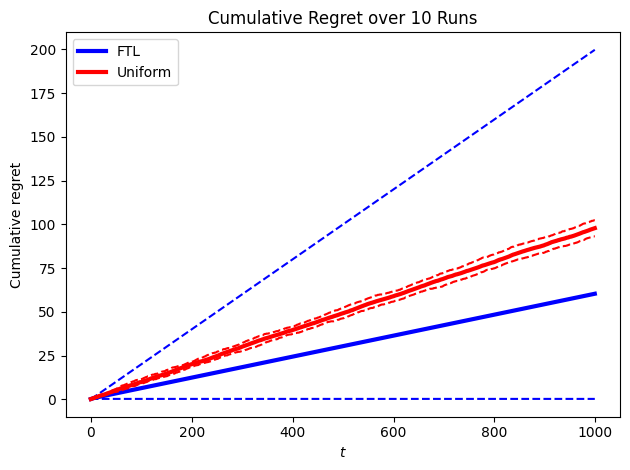

In [40]:
plot_results(env_B, [ftl, ufm])

### Task 

Implement Epsilon Greedy ($\epsilon$) in the `EpsilonGreedy` class below, with the same structure (method definitions) as `FTL` and `Uniform` above.

In [41]:
class EpsilonGreedy:

    """ Epsilon Greedy """

    def __init__(self, n_arms: int, epsilon: float = 0.05) -> None:
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.clear()

    def clear(self) -> None:
        self.arms_samples = np.zeros(self.n_arms)
        self.cumulative_rewards = np.zeros(self.n_arms)

    def act(self) -> int:
        action_greedy = 1
        probability_greedy = 1 - self.epsilon
        probability_explore = self.epsilon

        action_chosen = np.random.choice(2, p = [probability_explore, probability_greedy])

        if action_chosen == action_greedy:
            if (min(self.arms_samples) == 0):
                return randmax(-self.arms_samples)
            else:
                return randmax(self.cumulative_rewards/self.arms_samples)
        else:
            return np.random.randint(0, self.n_arms)

    def update(self, arm: int, reward: float) -> None:
        self.cumulative_rewards[arm] += reward
        self.arms_samples[arm] += 1

    def name(self):
        return f"e-Greedy({self.epsilon:.2f})"

Have a look at the performance of this method for different values of $\epsilon$. 

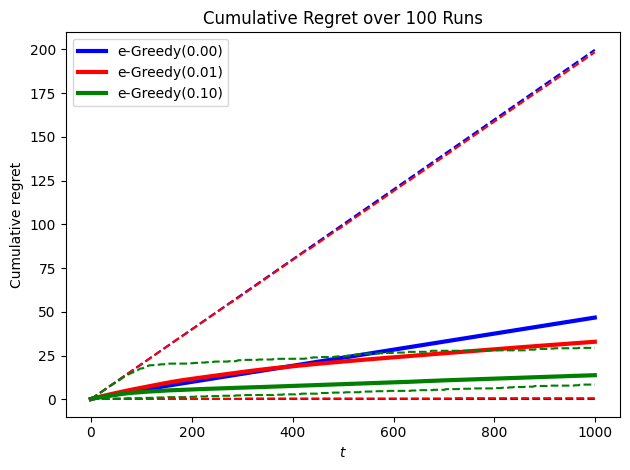

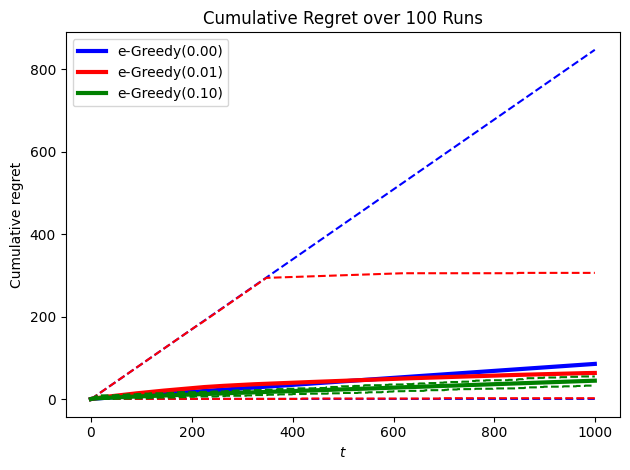

In [42]:
plot_results(env_B, [EpsilonGreedy(env_B.n_arms,0),EpsilonGreedy(env_B.n_arms,0.01),EpsilonGreedy(env_B.n_arms,0.1)], T=1000, N=100)
# 

# And with another bandit instance (Gaussian arms, this time)
env_G = GaussianMAB(2)
plot_results(env_G, [EpsilonGreedy(env_G.n_arms,0),EpsilonGreedy(env_G.n_arms,0.01),EpsilonGreedy(env_G.n_arms,0.1)], T=1000, N=100)

### Task 

Implement UCB($\alpha$) in the `UCB` class below, with the same structure (method definitions) as `FTL` and `Uniform` above.

In [43]:
class UCB():

    """UCB1 with parameter alpha"""

    def __init__(self, n_arms: int, alpha: float = 0.5) -> None:
        self.n_arms = n_arms
        self.alpha = alpha
        self.clear()
        # TODO 

    def clear(self) -> None:
        self.arms_samples = np.zeros(self.n_arms)
        self.cumulative_rewards = np.zeros(self.n_arms)


    def act(self) -> int:
        for arm in range(self.n_arms):
            if self.arms_samples[arm] == 0:
                return arm

        #? should it consider t?
        ucb_values = self.cumulative_rewards + np.sqrt((self.alpha * 1) / (self.arms_samples + 1e-10))

        return np.argmax(ucb_values)


    def update(self, arm: int, reward: float) -> None:
        self.arms_samples[arm] += 1
        self.cumulative_rewards[arm] += (reward - self.cumulative_rewards[arm]) / self.arms_samples[arm]

    def name(self):
        return f"UCB({self.alpha:.2f})"

We'll just check that your UCB implementation is working.

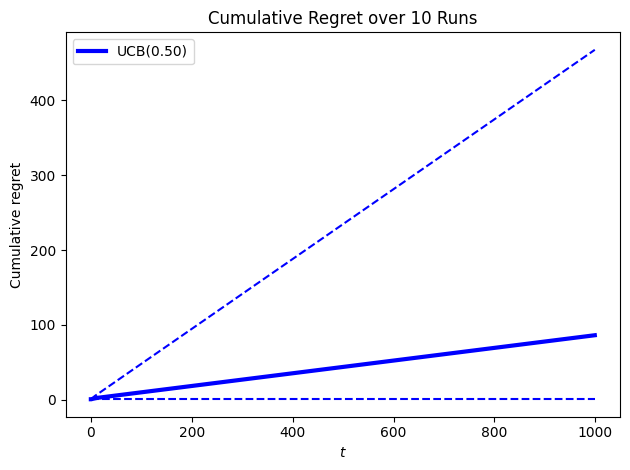

In [44]:
ucb = UCB(env_G.n_arms)
plot_results(env_G, [ucb], T=1000, N=10)
# ucb.render(env_G) # ,fname="bandit_ucb_trained.pdf"

Let's try a different bandit machine. Namely, we'll try a mixed multi-arm bandit, with arms of different reward distributions, but you could experiment with others also. 

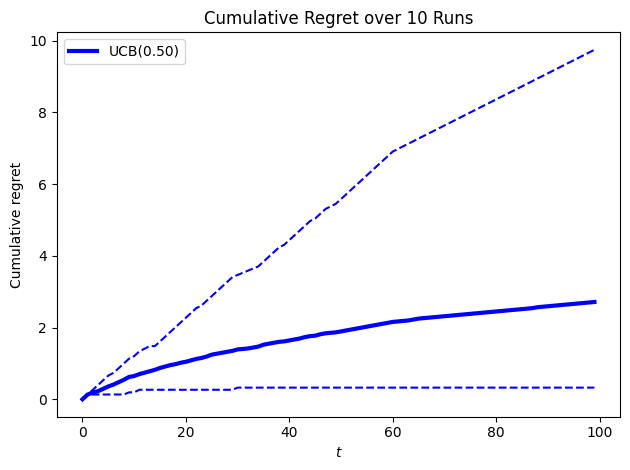

In [45]:
from bandit_machines import MixedMAB, TruncatedExponential, Bernoulli
# You should play around with different types of bandit environments here 
env_M = MixedMAB([TruncatedExponential(2, 1), Bernoulli(0.3), TruncatedExponential(3.5, 1)])
plot_results(env_M, [ucb], T=100, N=10)

### Task 

Implement Thompson Sampling in the class provided below, with the same structure as the methods you implemented above.

In [46]:
from scipy.stats import beta

In [47]:
class ThompsonSampling():

    def __init__(self, n_arms: int) -> None:
        ''' Bernoulli bandit machine (n_arms arms, each giving 0 or 1 with some probability) '''
        self.n_arms = n_arms
        self.clear()
        # TODO


    def clear(self) -> None:
        self.alpha = np.ones(self.n_arms)
        self.beta = np.ones(self.n_arms)


    def act(self) -> int:
        return np.argmax(np.random.beta(self.alpha, self.beta))


    def update(self, arm: int, reward: float) -> None:
        if reward == 1:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1


    def name(self):
        return "Thompson"

Finally, let's compare the three algorithms that you have implemented.

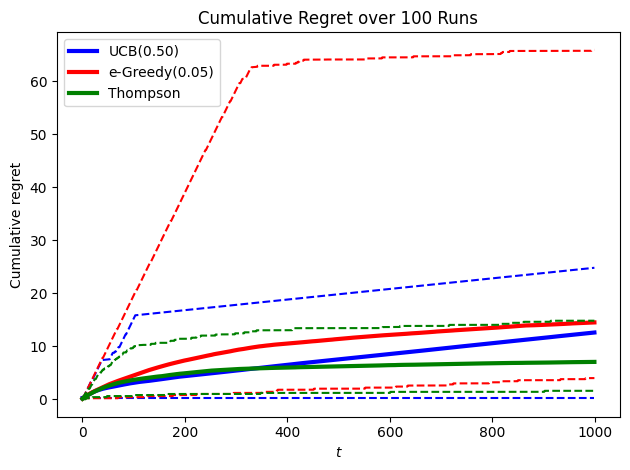

In [48]:
# Here, we carry out the comparison
plot_results(env_B, [UCB(env_B.n_arms), EpsilonGreedy(env_B.n_arms), ThompsonSampling(env_B.n_arms)], N=100)

### Something to Think About 

Regarding the Environment we used for Lab1 and Lab2, we could also use bandits in that scenario, namely, to if we had to decide on the best action to take *without* any observation. When considered as a 'rollout', this takes us closer and closer to Monte Carlo Tree Search and other algorithms in the domain of reinforcement learning. 